In [1]:
!nvidia-smi

Sat Sep 25 17:02:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   45C    P0    39W / 300W |     47MiB / 32508MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   

In [3]:
### https://ml-challenge.mercadolibre.com/
import pandas as pd
import cudf
import numpy as np
import gc
import xgboost as xgb 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

def reduce_mem(df):
    for col in df.columns:
        if df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
        if df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
    _ = gc.collect()
    return df

In [4]:
train = pd.read_parquet('train.parquet')
train = reduce_mem(train)
gc.collect()
print(train.shape)

valid = train.loc[train.date >'2021-03-01'].copy()
gc.collect()

train = train.loc[train.date <= '2021-03-01'].copy()
gc.collect()

train['dcount'] = train.groupby('sku')['date'].transform('cumcount')
train['dcount_max'] = train.groupby('sku')['date'].transform('count')
train['icount'] = train['dcount_max'] - train['dcount']-1
gc.collect()

valid['dcount'] = valid.groupby('sku')['date'].transform('cumcount')
valid['dcount_max'] = valid.groupby('sku')['date'].transform('count')
valid['icount'] = valid['dcount_max'] - valid['dcount']-1
gc.collect()

del train['target_stock']
del valid['target_stock']

train.shape, valid.shape

(37660279, 20)


((18091368, 22), (19568911, 22))

In [5]:
train.columns

Index(['sku', 'date', 'sold_quantity', 'current_price', 'currency',
       'listing_type', 'shipping_logistic_type', 'shipping_payment',
       'minutes_active', 'month', 'dow', 'item_domain_id', 'item_id',
       'site_id', 'product_id', 'product_family_id', 'item_title_id',
       'item_title_0', 'item_title_1', 'dcount', 'dcount_max', 'icount'],
      dtype='object')

In [6]:
train.tail()

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,month,...,item_id,site_id,product_id,product_family_id,item_title_id,item_title_0,item_title_1,dcount,dcount_max,icount
31651969,660915,2021-02-25,0,99.980003,1,0,0,1,0.0,2,...,429944,1,1,1,397588,246387,351225,24,29,4
31651970,660915,2021-02-26,0,99.980003,1,0,0,1,0.0,2,...,429944,1,1,1,397588,246387,351225,25,29,3
31651971,660915,2021-02-27,0,99.980003,1,0,0,1,0.0,2,...,429944,1,1,1,397588,246387,351225,26,29,2
31651972,660915,2021-02-28,0,99.980003,1,0,0,1,0.0,2,...,429944,1,1,1,397588,246387,351225,27,29,1
31651973,660915,2021-03-01,0,89.980003,1,0,0,1,0.0,3,...,429944,1,1,1,397588,246387,351225,28,29,0


In [7]:
valid.tail()

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,month,...,item_id,site_id,product_id,product_family_id,item_title_id,item_title_0,item_title_1,dcount,dcount_max,icount
31651999,660915,2021-03-27,0,79.989998,1,0,0,1,0.0,3,...,429944,1,1,1,397588,246387,351225,25,30,4
31652000,660915,2021-03-28,0,79.989998,1,0,0,1,0.0,3,...,429944,1,1,1,397588,246387,351225,26,30,3
31652001,660915,2021-03-29,0,79.989998,1,0,0,1,0.0,3,...,429944,1,1,1,397588,246387,351225,27,30,2
31652002,660915,2021-03-30,0,99.989998,1,0,0,1,0.0,3,...,429944,1,1,1,397588,246387,351225,28,30,1
31652003,660915,2021-03-31,0,99.989998,1,0,0,1,0.0,3,...,429944,1,1,1,397588,246387,351225,29,30,0


# Build local Validation

In [8]:
%%time
print(valid.shape)
valid['sum_sell'] = valid.groupby('sku')['sold_quantity'].transform('sum')
valid = valid.loc[(valid.dcount_max==30)&(valid.sum_sell>0)].copy()
print(valid.shape)
valid['cs_sell'] = valid.groupby('sku')['sold_quantity'].transform('cumsum')

dt = valid.loc[valid.sold_quantity>0].groupby('sku')['cs_sell'].apply(list).reset_index(name='sells')
np.random.seed(1)
dt['target_stock'] = dt['sells'].apply(lambda x: np.random.choice(x) )
del dt['sells']
dt

(19568911, 22)
(17303490, 23)
CPU times: user 30.8 s, sys: 1.8 s, total: 32.6 s
Wall time: 32.4 s


,sku,target_stock
0,0,11
1,1,15
2,3,1
3,4,2
4,5,12
...,...,...
576778,660911,11
576779,660912,3
576780,660913,2
576781,660914,3


In [9]:
#merge target_stock to train and validation

valid = valid.merge(dt[['sku', 'target_stock']], on='sku', how='left')
train = train.merge(dt[['sku', 'target_stock']], on='sku', how='left')

valid.target_stock.value_counts()

1        2244570
2        1863660
3        1601700
4        1378200
5        1181310
          ...   
1099          30
1098          30
1097          30
1095          30
30030         30
Name: target_stock, Length: 1344, dtype: int64

In [10]:
valid['target'] = 1 *(valid['cs_sell'] >= valid['target_stock'])
print( valid['target'].mean() )


ytrue = valid.pivot(index='sku', columns='dcount', values='target').reset_index()
ytrue = ytrue.reset_index(drop=True)
vals = ytrue.loc[:,range(30)].mean(0).values
vals[1:] = vals[1:] - vals[:-1]

valid['ypred'] = 1/30
VAL = valid.pivot(index='sku', columns='dcount', values='ypred').reset_index()
VAL = VAL.reset_index(drop=True)
VAL = VAL.fillna(1/30)
# for i in range(30):
#     VAL[i] = vals[i]
    
def metric( ytrue, ypred ):
    tmp = ypred.loc[:,range(30)].cumsum(1).values.copy()
    tmp[tmp>1] = 1
    tmp[tmp<0] = 0
    tmp /= tmp.max(1, keepdims=True)
    return np.sum( (ytrue.loc[:,range(30)].values - tmp)**2 ) / ytrue.shape[0]    

def metric_at( ytrue, ypred, at=0 ):
    tmp = ypred.loc[:,range(30)].cumsum(1).values.copy()
    tmp[tmp>1] = 1
    tmp[tmp<0] = 0
    tmp /= tmp.max(1, keepdims=True)
    return np.mean( (ytrue.loc[:,at].values - tmp[:,at])**2 ) 

metric( ytrue, VAL )

0.5184950550438091


5.1984754231660775

# Build Features

In [11]:
%%time

train['sell_lag'] = train['sold_quantity'] * train['minutes_active']
train['sell_lag'] = train.groupby('sku')['sell_lag'].transform('cumsum')
train['sell_act'] = train.groupby('sku')['minutes_active'].transform('cumsum')
train['sell_true'] = train['sell_lag'] / (train['sell_act']+1)
train['sell_true'] = train['sell_true'] / train['target_stock']
train['sell_lag_1'] = train['sell_true'] + train.groupby('sku')['sell_true'].shift(1).fillna(0)
train['sell_lag_2'] = train['sell_lag_1'] + train.groupby('sku')['sell_true'].shift(2).fillna(0)
train['sell_lag_3'] = train['sell_lag_2'] + train.groupby('sku')['sell_true'].shift(3).fillna(0)
train['sell_lag_4'] = train['sell_lag_3'] + train.groupby('sku')['sell_true'].shift(4).fillna(0)
train['sell_lag_5'] = train['sell_lag_4'] + train.groupby('sku')['sell_true'].shift(5).fillna(0)
train['sell_lag_6'] = train['sell_lag_5'] + train.groupby('sku')['sell_true'].shift(6).fillna(0)
train['sell_lag_7'] = train['sell_lag_6'] + train.groupby('sku')['sell_true'].shift(7).fillna(0)
train['sell_lag_8'] = train['sell_lag_7'] + train.groupby('sku')['sell_true'].shift(8).fillna(0)
train['sell_lag_9'] = train['sell_lag_8'] + train.groupby('sku')['sell_true'].shift(9).fillna(0)
train['sell_lag_10'] = train['sell_lag_9'] + train.groupby('sku')['sell_true'].shift(10).fillna(0)
train['sell_lag_11'] = train['sell_lag_10'] + train.groupby('sku')['sell_true'].shift(11).fillna(0)
train['sell_lag_12'] = train['sell_lag_11'] + train.groupby('sku')['sell_true'].shift(12).fillna(0)
train['sell_lag_13'] = train['sell_lag_12'] + train.groupby('sku')['sell_true'].shift(13).fillna(0)
train['sell_lag_14'] = train['sell_lag_13'] + train.groupby('sku')['sell_true'].shift(14).fillna(0)

train['price_lag_1'] = (train['current_price'] - train.groupby('sku')['current_price'].shift(1)) #/ (train['current_price']+1)
train['price_lag_2'] = (train['current_price'] - train.groupby('sku')['current_price'].shift(2)) #/ (train['current_price']+1)
train['price_lag_3'] = (train['current_price'] - train.groupby('sku')['current_price'].shift(3)) #/ (train['current_price']+1)
train['price_lag_4'] = (train['current_price'] - train.groupby('sku')['current_price'].shift(4)) #/ (train['current_price']+1)
train['price_lag_5'] = (train['current_price'] - train.groupby('sku')['current_price'].shift(5)) #/ (train['current_price']+1)
train['price_lag_6'] = (train['current_price'] - train.groupby('sku')['current_price'].shift(6)) #/ (train['current_price']+1)
train['price_lag_7'] = (train['current_price'] - train.groupby('sku')['current_price'].shift(7)) #/ (train['current_price']+1)

train['act_lag_1'] = train.groupby('sku')['minutes_active'].shift(1).bfill()
train['act_lag_2'] = train.groupby('sku')['minutes_active'].shift(2).bfill()
train['act_lag_3'] = train.groupby('sku')['minutes_active'].shift(3).bfill()
train['act_lag_4'] = train.groupby('sku')['minutes_active'].shift(4).bfill()
train['act_lag_5'] = train.groupby('sku')['minutes_active'].shift(5).bfill()
train['act_lag_6'] = train.groupby('sku')['minutes_active'].shift(6).bfill()
train['act_lag_7'] = train.groupby('sku')['minutes_active'].shift(7).bfill()

train['shipping_logistic_type_lag_1'] = train.groupby('sku')['shipping_logistic_type'].shift(1).bfill()

train['sold_quantity_log'] = np.log1p( train['sold_quantity'] )
train['sum_sells_1'] = train.groupby(['item_domain_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_2'] = train.groupby(['item_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_3'] = train.groupby(['item_title_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_4'] = train.groupby(['product_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_5'] = train.groupby(['product_family_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_6'] = train.groupby(['currency','listing_type','shipping_logistic_type','shipping_payment','site_id','dcount'])['sold_quantity_log'].transform('sum')

train['sold_lag_1'] = train.groupby('sku')['sold_quantity'].shift(1).fillna(0)
train['sold_lag_2'] = train.groupby('sku')['sold_quantity'].shift(2).fillna(0)
train['sold_lag_3'] = train.groupby('sku')['sold_quantity'].shift(3).fillna(0)
train['sold_lag_4'] = train.groupby('sku')['sold_quantity'].shift(4).fillna(0)
train['sold_lag_5'] = train.groupby('sku')['sold_quantity'].shift(5).fillna(0)
train['sold_lag_6'] = train.groupby('sku')['sold_quantity'].shift(6).fillna(0)
train['sold_lag_7'] = train.groupby('sku')['sold_quantity'].shift(7).fillna(0)

CPU times: user 37.3 s, sys: 7.69 s, total: 45 s
Wall time: 45 s


# Target is the prob that next day sells all target_stock

<AxesSubplot:>

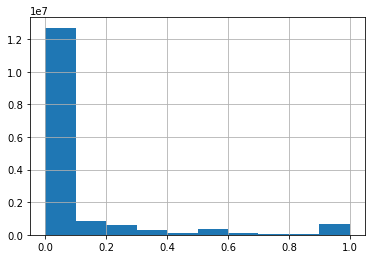

In [12]:
train['target'] = (train['sold_quantity'] / train['target_stock']).clip(0,1)
train['target'] = train.groupby('sku')['target'].shift(-1)
train['target'].hist()

In [13]:
train['target'].mean()

0.08944522267845056

In [14]:
features = [
    'sold_quantity',
    'current_price',
    'shipping_logistic_type',
    'minutes_active',
    'item_domain_id',
    'item_id',
    'item_title_id',
    'target_stock',              
    'sell_lag', 'sell_act', 'sell_true', 
    'sell_lag_1', 'sell_lag_2', 'sell_lag_3', 'sell_lag_4', 'sell_lag_5', 'sell_lag_6', 'sell_lag_7', 'sell_lag_8', 'sell_lag_9', 'sell_lag_10', 'sell_lag_11', 'sell_lag_12', 'sell_lag_13', 'sell_lag_14',
    'price_lag_1', 'price_lag_2', 'price_lag_3', 'price_lag_4', 'price_lag_5', 'price_lag_6', 'price_lag_7',
    'act_lag_1', 'act_lag_2', 'act_lag_3', 'act_lag_4',
    'shipping_logistic_type_lag_1',
    'sold_quantity_log', 
    'sum_sells_1', 'sum_sells_2', 'sum_sells_3', 'sum_sells_4', 'sum_sells_5', 'sum_sells_6',
    'sold_lag_1', 'sold_lag_2', 'sold_lag_3', 'sold_lag_4', 'sold_lag_5', 'sold_lag_6', 'sold_lag_7'
           ]
train[features].head()

,sold_quantity,current_price,shipping_logistic_type,minutes_active,item_domain_id,item_id,item_title_id,target_stock,sell_lag,sell_act,...,sum_sells_4,sum_sells_5,sum_sells_6,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_4,sold_lag_5,sold_lag_6,sold_lag_7
0,0,172.789993,1,0.000000,46,83220,79378,11.0,0.0,0.000000,...,176251.743502,0.000000,39.033102,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,172.789993,1,0.000000,46,83220,79378,11.0,0.0,0.000000,...,184917.319373,0.693147,22.159365,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,179.990005,1,872.650024,46,83220,79378,11.0,0.0,872.650024,...,190207.253350,1.791759,30.412593,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,179.990005,1,1440.000000,46,83220,79378,11.0,0.0,2312.649902,...,186399.494680,3.871201,35.235803,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,179.990005,1,1440.000000,46,83220,79378,11.0,0.0,3752.649902,...,175571.903516,2.079442,43.488208,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
import xgboost as xgb

params = {
    'learning_rate': 0.04,
    'max_depth': 8,
    'subsample': 0.50,
    'colsample_bytree': 0.50,
    'min_child_weight': 1,
    'random_state': 2021,
    'objective': "reg:squarederror",
    'base_score': 0.5,
    'tree_method': 'gpu_hist',
    'verbosity': 1,
}

MODELS = []
NROUNDS = []
OOF = pd.DataFrame()
for fold in [5,4,3,2,1,0]:
    
    ind = (train.icount >fold)&(train.target.notnull())&(train.sell_lag_1.notnull())&(train.sku.isin(valid.sku)) 
    print(fold, np.sum(ind))
    dtrain = xgb.DMatrix( train.loc[ind, features], label=train.loc[ind,'target'] ) ; gc.collect()
    if fold>0:
        ind = (train.icount<=fold)&(train.target.notnull())
        dvalid = xgb.DMatrix( train.loc[ind, features], label=train.loc[ind,'target'] ) ; gc.collect()

    if fold>0:
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=3000,
            evals=[(dvalid,'valid')],
            early_stopping_rounds=33,
            verbose_eval=100,
            ) ; gc.collect()
        NROUNDS.append(model.best_iteration)
    else:
        nround = int(np.mean(NROUNDS[-4:])+15)
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=nround,
            ) ; gc.collect()
        NROUNDS.append(nround)
    MODELS.append(model)
    
    ind = (train.icount==fold)
    tmp = train.loc[ind].copy()
    dtest = xgb.DMatrix( tmp[features], label=tmp['target'] ) ; gc.collect()
    tmp = tmp.reset_index(drop=True)
    
    ypred = 1*MODELS[0].predict(dtest)
    N =1
    SN = 1
    if len(MODELS)>1:
        for m in MODELS[1:]:
            ypred += (N*m.predict(dtest))
            SN+=N
        ypred /= SN
    
    tmp['ypred'] = np.clip(ypred,0,1)
    
    if fold>0:
        print(fold,  np.sum( (tmp.loc[tmp.target.notnull(),'target'].values - tmp.loc[tmp.target.notnull(),'ypred'].values)**2 ) / tmp['sku'].nunique(), np.mean(NROUNDS) )
    
    OOF = OOF.append(tmp)

OOF = OOF.sort_values(['sku','date']).reset_index(drop=True)
OOF.head()

5 12851925
[0]	valid-rmse:0.45147
[100]	valid-rmse:0.18846
[200]	valid-rmse:0.18769
[300]	valid-rmse:0.18753
[400]	valid-rmse:0.18747
[500]	valid-rmse:0.18741
[600]	valid-rmse:0.18740
[612]	valid-rmse:0.18740
5 0.03318742992410859 580.0
4 13423539
[0]	valid-rmse:0.45171
[100]	valid-rmse:0.18711
[200]	valid-rmse:0.18648
[300]	valid-rmse:0.18643
[364]	valid-rmse:0.18639
4 0.031226931529908453 455.5
3 13996445
[0]	valid-rmse:0.45157
[100]	valid-rmse:0.18693
[200]	valid-rmse:0.18653
[218]	valid-rmse:0.18652
3 0.02898378830786868 365.3333333333333
2 14570429
[0]	valid-rmse:0.45032
[100]	valid-rmse:0.19004
[156]	valid-rmse:0.18984
2 0.028923741855644017 304.75
1 15144834
[0]	valid-rmse:0.44706
[100]	valid-rmse:0.19894
[200]	valid-rmse:0.19848
[300]	valid-rmse:0.19816
[400]	valid-rmse:0.19801
[500]	valid-rmse:0.19787
[600]	valid-rmse:0.19782
[683]	valid-rmse:0.19779
1 0.03569996471492295 374.0
0 15719583


,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,month,...,sum_sells_6,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_4,sold_lag_5,sold_lag_6,sold_lag_7,target,ypred
0,0,2021-02-24,0,179.990005,0,0,1,0,1440.0,2,...,47.171362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001394
1,0,2021-02-25,0,179.990005,0,0,1,0,1440.0,2,...,30.358521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001180
2,0,2021-02-26,0,179.990005,0,0,1,0,1440.0,2,...,28.377037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0,2021-02-27,0,179.990005,0,0,1,0,1440.0,2,...,13.184820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0,2021-02-28,0,179.990005,0,0,1,0,1440.0,2,...,5.950643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [16]:
OOF.loc[OOF.icount==0]

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,month,...,sum_sells_6,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_4,sold_lag_5,sold_lag_6,sold_lag_7,target,ypred
5,0,2021-03-01,0,179.990005,0,0,1,0,1440.000000,3,...,19.304118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.000852
11,1,2021-03-01,2,135.899994,0,1,0,0,1440.000000,3,...,13141.450954,0.0,1.0,0.0,0.0,0.0,2.0,2.0,NaN,0.065253
17,3,2021-03-01,0,399.000000,1,1,0,0,0.000000,3,...,18270.640989,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,0.011033
23,4,2021-03-01,2,118.000000,0,1,0,0,243.278488,3,...,13141.450954,0.0,1.0,0.0,1.0,0.0,12.0,1.0,NaN,0.393693
29,5,2021-03-01,1,579.630005,1,1,0,0,1440.000000,3,...,18270.640989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.046046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3823186,660911,2021-03-01,1,11.900000,0,0,0,1,1440.000000,3,...,36710.160039,1.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,0.048832
3823192,660912,2021-03-01,0,99.000000,1,0,0,1,1440.000000,3,...,30591.989318,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,0.107952
3823198,660913,2021-03-01,0,149.899994,0,1,0,0,1440.000000,3,...,13141.450954,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0.088934
3823204,660914,2021-03-01,0,59.990002,0,1,0,1,1440.000000,3,...,36865.966890,1.0,0.0,1.0,0.0,3.0,0.0,0.0,NaN,0.184936


In [17]:
imp = pd.DataFrame().from_dict(MODELS[-1].get_fscore(), orient='index').sort_values(0, ascending=False).reset_index()
imp.head(10)

,index,0
0,sell_act,3940
1,target_stock,3746
2,sell_true,3333
3,sold_quantity,3024
4,sum_sells_6,3001
5,sell_lag_1,2852
6,current_price,2556
7,sum_sells_4,2486
8,sell_lag,2468
9,minutes_active,2281


In [18]:
imp.tail(10)

,index,0
41,shipping_logistic_type_lag_1,955
42,sell_lag_6,897
43,sold_lag_4,851
44,sell_lag_8,851
45,sold_lag_6,845
46,price_lag_1,845
47,sold_lag_7,755
48,act_lag_4,728
49,shipping_logistic_type,681
50,sell_lag_9,679


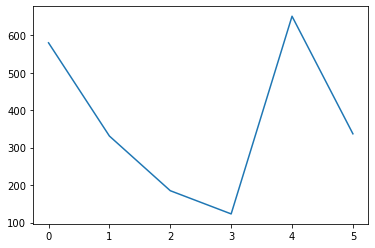

In [19]:
plt.plot(NROUNDS)

<AxesSubplot:>

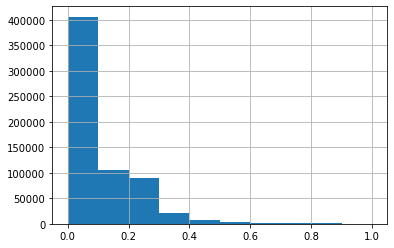

In [20]:
OOF.loc[OOF.icount==0,'ypred'].hist()

In [21]:
np.sum( (OOF.loc[OOF.target.notnull(),'target'].values - OOF.loc[OOF.target.notnull(),'ypred'].values)**2 ) / OOF['sku'].nunique()

0.1573822161950747

In [22]:
PRED = OOF.loc[OOF.icount==0].groupby('sku')['ypred'].agg('mean').reset_index()
PRED['ypred'] = PRED['ypred'].clip(0,1)
PRED

,sku,ypred
0,0,0.000852
1,1,0.065253
2,3,0.011033
3,4,0.393693
4,5,0.046046
...,...,...
639346,660911,0.048832
639347,660912,0.107952
639348,660913,0.088934
639349,660914,0.184936


In [23]:
val = VAL.copy()
for i in range(1,30):
    val[i] = 1. / 30
val[29] = 1.

for i in range(6):
    val[i] = (1.0/(i+1))*val[['sku']].merge(PRED, on='sku', how='left')['ypred'].values
    val[i] = val[i].fillna(1/30)
    val[i] = val[i].clip(0,1)

for i in range(1,30):
    val[i] = (val[i-1] + val[i] ).clip(0,1)
        
for i in range(29,0,-1):
    val[i] = val[i] - val[i-1]
    val[i] = val[i].clip(0,1)

print( 'Validation score:', metric( ytrue, val ), metric_at( ytrue, val, 0 ) )

Validation score: 4.1258648225455685 0.035703035644537945


In [24]:
val.head(20)

dcount,sku,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,28,29
0,0,0.000852,0.000426,0.000284,0.000213,0.000170,0.000142,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.231247
1,1,0.065253,0.032627,0.021751,0.016313,0.013051,0.010876,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.073462
2,3,0.011033,0.005517,0.003678,0.002758,0.002207,0.001839,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.206302
3,4,0.393693,0.196847,0.131231,0.098423,0.078739,0.065616,0.033333,0.002118,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5,0.046046,0.023023,0.015349,0.011511,0.009209,0.007674,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.120522
5,6,0.146711,0.073356,0.048904,0.036678,0.029342,0.024452,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.007224,0.000000,0.000000,0.000000,0.000000
6,7,0.023512,0.011756,0.007837,0.005878,0.004702,0.003919,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.175729
7,9,0.241959,0.120979,0.080653,0.060490,0.048392,0.040326,0.033333,0.033333,0.033333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,10,0.165668,0.082834,0.055223,0.041417,0.033134,0.027611,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.027446,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,11,0.050606,0.025303,0.016869,0.012651,0.010121,0.008434,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.109350


<AxesSubplot:xlabel='dcount'>

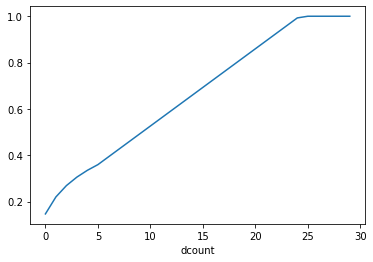

In [25]:
val.loc[5,range(30)].cumsum().plot()

<AxesSubplot:xlabel='dcount'>

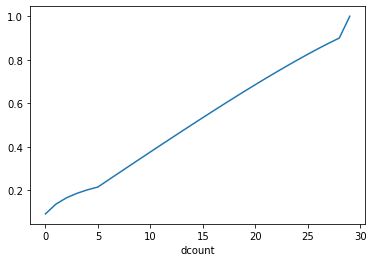

In [26]:
val.loc[:,range(30)].cumsum(1).mean().plot()

In [27]:
val.to_csv('validation-day-1-B.csv', index=False)

# Now train using 100% of the trainset

In [28]:
train = pd.read_parquet('train.parquet')
train = reduce_mem(train)
gc.collect()
print(train.shape)

train['dcount'] = train.groupby('sku')['date'].transform('cumcount')
train['dcount_max'] = train.groupby('sku')['date'].transform('count')
train['icount'] = train['dcount_max'] - train['dcount']-1
gc.collect()

train.shape

(37660279, 20)


(37660279, 23)

In [29]:
%%time

train['sell_lag'] = train['sold_quantity'] * train['minutes_active']
train['sell_lag'] = train.groupby('sku')['sell_lag'].transform('cumsum')
train['sell_act'] = train.groupby('sku')['minutes_active'].transform('cumsum')
train['sell_true'] = train['sell_lag'] / (train['sell_act']+1)
train['sell_true'] = train['sell_true'] / train['target_stock']
train['sell_lag_1'] = train['sell_true'] + train.groupby('sku')['sell_true'].shift(1).fillna(0)
train['sell_lag_2'] = train['sell_lag_1'] + train.groupby('sku')['sell_true'].shift(2).fillna(0)
train['sell_lag_3'] = train['sell_lag_2'] + train.groupby('sku')['sell_true'].shift(3).fillna(0)
train['sell_lag_4'] = train['sell_lag_3'] + train.groupby('sku')['sell_true'].shift(4).fillna(0)
train['sell_lag_5'] = train['sell_lag_4'] + train.groupby('sku')['sell_true'].shift(5).fillna(0)
train['sell_lag_6'] = train['sell_lag_5'] + train.groupby('sku')['sell_true'].shift(6).fillna(0)
train['sell_lag_7'] = train['sell_lag_6'] + train.groupby('sku')['sell_true'].shift(7).fillna(0)
train['sell_lag_8'] = train['sell_lag_7'] + train.groupby('sku')['sell_true'].shift(8).fillna(0)
train['sell_lag_9'] = train['sell_lag_8'] + train.groupby('sku')['sell_true'].shift(9).fillna(0)
train['sell_lag_10'] = train['sell_lag_9'] + train.groupby('sku')['sell_true'].shift(10).fillna(0)
train['sell_lag_11'] = train['sell_lag_10'] + train.groupby('sku')['sell_true'].shift(11).fillna(0)
train['sell_lag_12'] = train['sell_lag_11'] + train.groupby('sku')['sell_true'].shift(12).fillna(0)
train['sell_lag_13'] = train['sell_lag_12'] + train.groupby('sku')['sell_true'].shift(13).fillna(0)
train['sell_lag_14'] = train['sell_lag_13'] + train.groupby('sku')['sell_true'].shift(14).fillna(0)

train['price_lag_1'] = (train['current_price'] - train.groupby('sku')['current_price'].shift(1)) #/ (train['current_price']+1)
train['price_lag_2'] = (train['current_price'] - train.groupby('sku')['current_price'].shift(2)) #/ (train['current_price']+1)
train['price_lag_3'] = (train['current_price'] - train.groupby('sku')['current_price'].shift(3)) #/ (train['current_price']+1)
train['price_lag_4'] = (train['current_price'] - train.groupby('sku')['current_price'].shift(4)) #/ (train['current_price']+1)
train['price_lag_5'] = (train['current_price'] - train.groupby('sku')['current_price'].shift(5)) #/ (train['current_price']+1)
train['price_lag_6'] = (train['current_price'] - train.groupby('sku')['current_price'].shift(6)) #/ (train['current_price']+1)
train['price_lag_7'] = (train['current_price'] - train.groupby('sku')['current_price'].shift(7)) #/ (train['current_price']+1)

train['act_lag_1'] = train.groupby('sku')['minutes_active'].shift(1).bfill()
train['act_lag_2'] = train.groupby('sku')['minutes_active'].shift(2).bfill()
train['act_lag_3'] = train.groupby('sku')['minutes_active'].shift(3).bfill()
train['act_lag_4'] = train.groupby('sku')['minutes_active'].shift(4).bfill()
train['act_lag_5'] = train.groupby('sku')['minutes_active'].shift(5).bfill()
train['act_lag_6'] = train.groupby('sku')['minutes_active'].shift(6).bfill()
train['act_lag_7'] = train.groupby('sku')['minutes_active'].shift(7).bfill()

train['shipping_logistic_type_lag_1'] = train.groupby('sku')['shipping_logistic_type'].shift(1).bfill()

train['sold_quantity_log'] = np.log1p( train['sold_quantity'] )
train['sum_sells_1'] = train.groupby(['item_domain_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_2'] = train.groupby(['item_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_3'] = train.groupby(['item_title_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_4'] = train.groupby(['product_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_5'] = train.groupby(['product_family_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_6'] = train.groupby(['currency','listing_type','shipping_logistic_type','shipping_payment','site_id','dcount'])['sold_quantity_log'].transform('sum')

train['sold_lag_1'] = train.groupby('sku')['sold_quantity'].shift(1).fillna(0)
train['sold_lag_2'] = train.groupby('sku')['sold_quantity'].shift(2).fillna(0)
train['sold_lag_3'] = train.groupby('sku')['sold_quantity'].shift(3).fillna(0)
train['sold_lag_4'] = train.groupby('sku')['sold_quantity'].shift(4).fillna(0)
train['sold_lag_5'] = train.groupby('sku')['sold_quantity'].shift(5).fillna(0)
train['sold_lag_6'] = train.groupby('sku')['sold_quantity'].shift(6).fillna(0)
train['sold_lag_7'] = train.groupby('sku')['sold_quantity'].shift(7).fillna(0)

CPU times: user 1min 12s, sys: 14.8 s, total: 1min 27s
Wall time: 1min 26s


<AxesSubplot:>

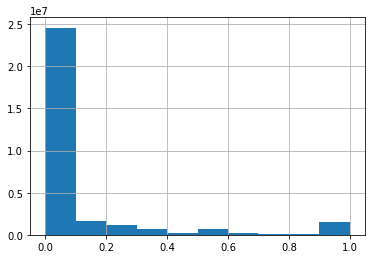

In [30]:
train['target'] = (train['sold_quantity'] / train['target_stock']).clip(0,1)
train['target'] = train.groupby('sku')['target'].shift(-1)
train['target'].hist()

In [31]:
import xgboost as xgb

params = {
    'learning_rate': 0.04,
    'max_depth': 8,
    'subsample': 0.50,
    'colsample_bytree': 0.50,
    'min_child_weight': 1,
    'random_state': 2021,
    'objective': "reg:squarederror",
    'base_score': 0.5,
    'tree_method': 'gpu_hist',
    'verbosity': 1,
}

MODELS = []
NROUNDS = []
OOF = pd.DataFrame()
for fold in [5,4,3,2,1,0]:
    
    ind = (train.icount >fold)&(train.target.notnull())&(train.sell_lag_1.notnull())&(train.sku.isin(valid.sku)) 
    print(fold, np.sum(ind))
    dtrain = xgb.DMatrix( train.loc[ind, features], label=train.loc[ind,'target'] ) ; gc.collect()
    if fold>0:
        ind = (train.icount<=fold)&(train.target.notnull())
        dvalid = xgb.DMatrix( train.loc[ind, features], label=train.loc[ind,'target'] ) ; gc.collect()

    if fold>0:
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=3000,#np.mean(NROUNDS),
            evals=[(dvalid,'valid')],
            early_stopping_rounds=33,
            verbose_eval=100,
            ) ; gc.collect()
        NROUNDS.append(model.best_iteration)
    else:
        nround = int(np.mean(NROUNDS[-4:])+15)
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=nround,
            #evals=[(dvalid,'valid')],
            #early_stopping_rounds=30,
            #verbose_eval=100,
            ) ; gc.collect()
        NROUNDS.append(nround)
    MODELS.append(model)
    
    ind = (train.icount==fold)
    tmp = train.loc[ind].copy()
    dtest = xgb.DMatrix( tmp[features], label=tmp['target'] ) ; gc.collect()
    tmp = tmp.reset_index(drop=True)
    
    ypred = 1*MODELS[0].predict(dtest)
    N =1
    SN = 1
    if len(MODELS)>1:
        for m in MODELS[1:]:
            ypred += (N*m.predict(dtest))
            SN+=N
        ypred /= SN#len(MODELS)
    
    tmp['ypred'] = np.clip(ypred,0,1)
    
    if fold>0:
        print(fold,  np.sum( (tmp.loc[tmp.target.notnull(),'target'].values - tmp.loc[tmp.target.notnull(),'ypred'].values)**2 ) / tmp['sku'].nunique(), np.mean(NROUNDS) )
    
    OOF = OOF.append(tmp)

OOF = OOF.sort_values(['sku','date']).reset_index(drop=True)
OOF.head()

5 25797763
[0]	valid-rmse:0.44918
[100]	valid-rmse:0.20184
[200]	valid-rmse:0.20034
[300]	valid-rmse:0.19994
[400]	valid-rmse:0.19976
[500]	valid-rmse:0.19967
[600]	valid-rmse:0.19963
[700]	valid-rmse:0.19960
[800]	valid-rmse:0.19958
[900]	valid-rmse:0.19956
[1000]	valid-rmse:0.19954
[1044]	valid-rmse:0.19954
5 0.02978556979334082 1011.0
4 26291687
[0]	valid-rmse:0.44809
[100]	valid-rmse:0.20436
[200]	valid-rmse:0.20289
[300]	valid-rmse:0.20250
[400]	valid-rmse:0.20235
[500]	valid-rmse:0.20227
[600]	valid-rmse:0.20222
[692]	valid-rmse:0.20220
4 0.02952702329316182 835.0
3 26785611
[0]	valid-rmse:0.44627
[100]	valid-rmse:0.20874
[200]	valid-rmse:0.20745
[300]	valid-rmse:0.20714
[400]	valid-rmse:0.20704
[500]	valid-rmse:0.20696
[600]	valid-rmse:0.20690
[668]	valid-rmse:0.20689
3 0.03582806776250173 768.6666666666666
2 27279535
[0]	valid-rmse:0.44602
[100]	valid-rmse:0.20834
[200]	valid-rmse:0.20696
[300]	valid-rmse:0.20658
[400]	valid-rmse:0.20642
[500]	valid-rmse:0.20637
[600]	valid-rms

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,target_stock,...,sum_sells_6,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_4,sold_lag_5,sold_lag_6,sold_lag_7,target,ypred
0,0,2021-03-26,0,179.990005,0,0,0,0,1440.0,1.0,...,12509.074521,2.0,4.0,1.0,2.0,0.0,0.0,0.0,1.0,0.526841
1,0,2021-03-27,1,179.990005,0,0,0,0,1440.0,1.0,...,10712.412259,0.0,2.0,4.0,1.0,2.0,0.0,0.0,0.0,0.531666
2,0,2021-03-28,0,179.990005,0,0,0,0,1440.0,1.0,...,10708.021126,1.0,0.0,2.0,4.0,1.0,2.0,0.0,0.0,0.441965
3,0,2021-03-29,0,179.990005,0,0,0,0,1440.0,1.0,...,13263.024322,0.0,1.0,0.0,2.0,4.0,1.0,2.0,0.0,0.385595
4,0,2021-03-30,0,179.990005,0,0,0,0,1440.0,1.0,...,13960.989972,0.0,0.0,1.0,0.0,2.0,4.0,1.0,0.0,0.331350


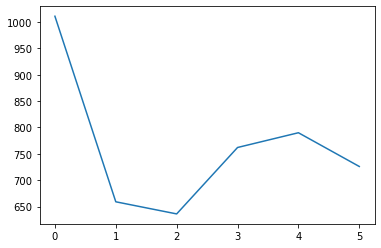

In [32]:
plt.plot(NROUNDS)

In [33]:
PRED = OOF.loc[OOF.icount==0].groupby('sku')['ypred'].agg('mean').reset_index()
PRED['ypred'] = PRED['ypred'].clip(0,1)
PRED

,sku,ypred
0,0,0.248907
1,1,0.051761
2,2,0.035248
3,3,0.084291
4,4,0.297003
...,...,...
660911,660911,0.088528
660912,660912,0.120498
660913,660913,0.074173
660914,660914,0.043086


In [34]:
test = pd.read_csv('../input/test_data.csv')
print( test.shape, test.sku.nunique() )
test = test.merge( PRED, on='sku', how='left' )
print( test.ypred.isnull().sum() )
test.head()

(551472, 2) 551472
0


,sku,target_stock,ypred
0,464801,3,0.068322
1,645793,4,0.057902
2,99516,8,0.329982
3,538100,8,0.156383
4,557191,10,0.059524


(551472, 30)


<AxesSubplot:>

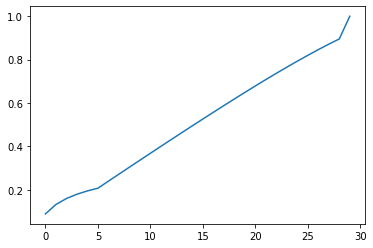

In [35]:
sub = pd.read_csv('../input/sample_submission.csv', header=None)
for i in range(30):
    sub[i] = 1. / 30
sub[29] = 1.
print( sub.shape )

for i in range(6):
    sub[i] = (1.0/(i+1))*test['ypred'].values
    sub[i] = sub[i].fillna(1/30)
    sub[i] = sub[i].clip(0,1)

for i in range(1,30):
    sub[i] = (sub[i-1] + sub[i] ).clip(0,1)

for i in range(29,0,-1):
    sub[i] = sub[i] - sub[i-1]
    sub[i] = sub[i].clip(0,1)

sub.loc[:,range(30)].cumsum(1).mean().plot()

In [36]:
sub.head(40)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.068322,0.034161,0.022774,0.017080,0.013664,0.011387,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.065945
1,0.057902,0.028951,0.019301,0.014475,0.011580,0.009650,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.091475
2,0.329982,0.164991,0.109994,0.082496,0.065996,0.054997,0.033333,0.033333,0.033333,0.033333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.156383,0.078191,0.052128,0.039096,0.031277,0.026064,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.016862,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.059524,0.029762,0.019841,0.014881,0.011905,0.009921,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.087498
5,0.533078,0.266539,0.177693,0.022690,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.219220,0.109610,0.073073,0.054805,0.043844,0.036537,0.033333,0.033333,0.033333,0.033333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.023444,0.011722,0.007815,0.005861,0.004689,0.003907,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.175895
8,0.092800,0.046400,0.030933,0.023200,0.018560,0.015467,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.005973
9,0.001003,0.000502,0.000334,0.000251,0.000201,0.000167,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.230876


In [37]:
sub.tail(40)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
551432,0.012742,0.006371,0.004247,0.003185,0.002548,0.002124,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.202116
551433,0.235682,0.117841,0.078561,0.058920,0.047136,0.039280,0.033333,0.033333,0.033333,0.033333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
551434,0.008220,0.004110,0.002740,0.002055,0.001644,0.001370,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.213195
551435,0.007382,0.003691,0.002461,0.001845,0.001476,0.001230,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.215248
551436,0.004111,0.002055,0.001370,0.001028,0.000822,0.000685,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.223262
551437,0.354343,0.177172,0.118114,0.088586,0.070869,0.059057,0.033333,0.033333,0.033333,0.031859,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
551438,0.041567,0.020784,0.013856,0.010392,0.008313,0.006928,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.131493
551439,0.086480,0.043240,0.028827,0.021620,0.017296,0.014413,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.021456
551440,0.002960,0.001480,0.000987,0.000740,0.000592,0.000493,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.226082
551441,0.006750,0.003375,0.002250,0.001688,0.001350,0.001125,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.216795


In [38]:
# Save to disk to submit
sub.to_csv('submission-day-1-B.csv', index=False, header=None, float_format='%.4f')
# 4.053150127061913